# DATA 607 - Machine Learning

## Class 8 &mdash; 2025.05.14 &mdash; Deep Learning

[Colab version](https://colab.research.google.com/drive/1WWpIJ5HKItIU7hy3xCSgsLe209fA4ICg?usp=sharing)

In [1]:
import requests
from io import BytesIO
from PIL import Image

import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models

### Using a pretrained model for inference

In [2]:
# Load the ResNet50 model (pretrained on ImageNet)
# ~25.6 million parameters
# He et al. (2015), "Deep Residual Learning for Image Recognition", https://arxiv.org/abs/1512.03385
model = models.resnet50(weights="IMAGENET1K_V2")
model.eval()  # Set to evaluation mode

# Get an image from the internet
response = requests.get(
    "https://upload.wikimedia.org/wikipedia/commons/4/44/Jelly_cc11.jpg"
)
img = Image.open(BytesIO(response.content))

# Define transformation to match ResNet50's expected input
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Apply transformation
x = transform(img).unsqueeze(0)  # Add batch dimension

# Run the image through the model
y_hat = model(x)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/mgreenbe/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 20.9MB/s]


In [3]:
transform(img).unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [4]:
y_hat.sum()  # unnormalized!

tensor(0.0435, grad_fn=<SumBackward0>)

In [5]:
y_hat = y_hat.detach().numpy().squeeze()
I = y_hat.argsort()[::-1]
print(I[:5])
print(y_hat[I[:5]])

[107 610 701 950 619]
[6.487066  1.1264646 0.8696004 0.6772967 0.646585 ]


In [6]:
classes = requests.get(
    "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
).json()
classes = np.array(classes)

In [7]:
classes[I[:5]]

array(['jellyfish', 'T-shirt', 'parachute', 'orange', 'lampshade'],
      dtype='<U32')

In [8]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Logistic regression with PyTorch

X.shape=torch.Size([5000, 2]), y.shape=torch.Size([5000, 1])


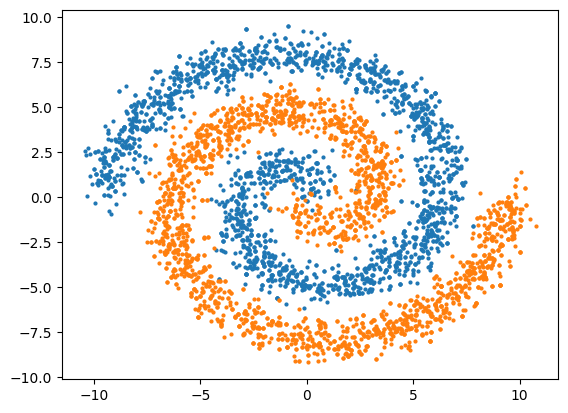

In [9]:
n = 2500
s = 0.6
k = 3
r0 = np.sqrt(np.random.uniform(size=n)) * k * np.pi
r1 = np.sqrt(np.random.uniform(size=n)) * k * np.pi
X0 = np.array([r0 * np.cos(r0), r0 * np.sin(r0)]).T + np.random.normal(
    0, s, size=(n, 2)
)
y0 = np.zeros(n)
X1 = np.array([r1 * np.cos(r1 + np.pi), r1 * np.sin(r1 + np.pi)]).T + np.random.normal(
    0, s, size=(n, 2)
)
y1 = np.ones(n)
X = np.vstack([X0, X1])
y = np.concatenate([y0, y1])
I = np.random.choice(range(2 * n), size=2 * n)
X = X[I, :]
y = y[I]

N = n
plt.plot(X[y == 0, 0][:N], X[y == 0, 1][:N], "o", ms=2)
plt.plot(X[y == 1, 0][:N], X[y == 1, 1][:N], "o", ms=2)

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

X = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(y.reshape(-1, 1).astype(np.float32))

print(f"X.shape={X.shape}, y.shape={y.shape}")

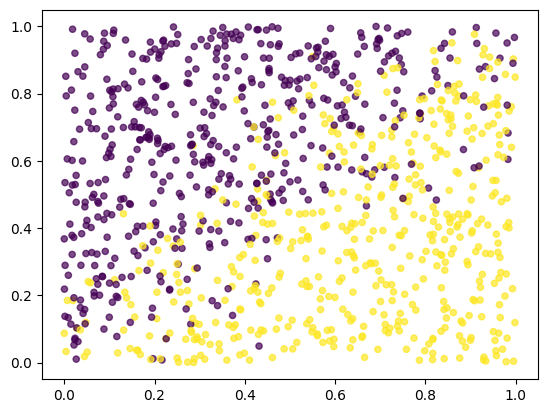

In [10]:
rng = np.random.default_rng()
X = rng.uniform(size=(1000, 2))
y = X[:, 0] > X[:, 1] + 0.2 * rng.normal(size=1000)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, alpha=0.7)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X, y)
accuracy_score(y, model.predict(X))

0.856

In [12]:
model.intercept_, model.coef_

(array([-0.01314002]), array([[ 6.08975603, -5.98391407]]))

# To PyTorch

In [13]:
x = torch.Tensor(X)
y = torch.Tensor(y)

bias = torch.Tensor([0.0])
weight = torch.rand(2)
bias.requires_grad_()
weight.requires_grad_()
print(bias, weight)

tensor([0.], requires_grad=True) tensor([0.3655, 0.9674], requires_grad=True)


$$
\operatorname{logit}(p) = (\text{bias}) + X(\text{weight}),\qquad
\operatorname{logit}(p)=\log\frac p{1-p}
$$

In [14]:
def model(x):
    logits = bias + x @ weight
    return logits

In [15]:
# *-multiplication vs @-multiplication
assert torch.allclose(x[:, 0] * weight[0] + x[:, 1] * weight[1], x @ weight)
assert torch.allclose(torch.sum(x * weight, axis=1), x @ weight)

In [16]:
def compute_loss(logits, y):
    loss = F.binary_cross_entropy_with_logits(logits, y)
    return loss

In [17]:
compute_loss(model(x), y)

tensor(0.8062, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [18]:
logits = model(x)
loss = compute_loss(logits, y)
loss.backward()

In [19]:
bias.grad, weight.grad

(tensor([0.1675]), tensor([0.0165, 0.1741]))

In [20]:
learning_rate = 1.0
with torch.no_grad():
    bias -= learning_rate * bias.grad
    weight -= learning_rate * weight.grad
    bias.grad.zero_()
    weight.grad.zero_()

In [21]:
compute_loss(model(x), y)

tensor(0.7555, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [22]:
x = torch.Tensor(X)
y = torch.Tensor(y)

bias = torch.Tensor([0.0])
weight = torch.rand(2)
bias.requires_grad_()
weight.requires_grad_()

learning_rate = 6.0
losses = []
for i in range(200):  # training loop
    logits = model(x)
    loss = compute_loss(logits, y)
    losses.append(loss.detach().item())

    loss.backward()

    with torch.no_grad():
        bias -= learning_rate * bias.grad
        weight -= learning_rate * weight.grad
        bias.grad.zero_()
        weight.grad.zero_()

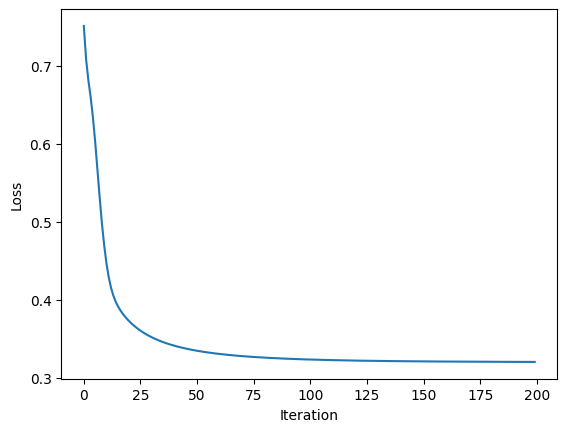

In [23]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [24]:
logits = model(x).detach()
labels = (logits > 0).numpy()
accuracy_score(y, labels)

0.857

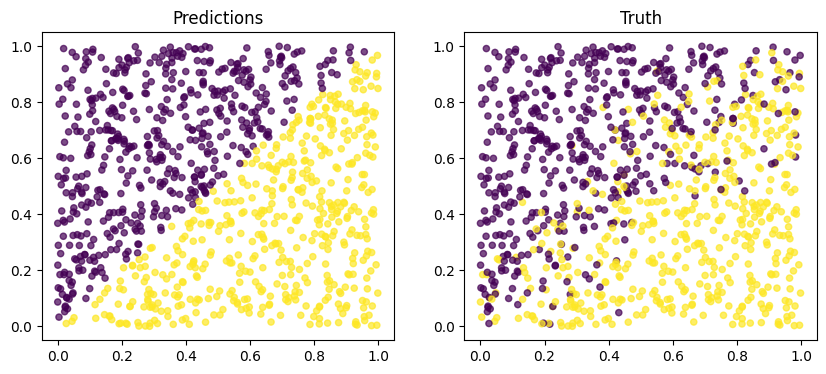

In [25]:
fig, (a0, a1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
a0.scatter(X[:, 0], X[:, 1], c=labels, s=20, alpha=0.7)
a0.set_title("Predictions")
a1.scatter(X[:, 0], X[:, 1], c=y, s=20, alpha=0.7)
a1.set_title("Truth")
plt.show()

### Stochastic gradient descent

In [26]:
x = torch.Tensor(X)
y = torch.Tensor(y)

bias = torch.Tensor([0.0])
weight = torch.rand(2)
bias.requires_grad_()
weight.requires_grad_()

learning_rate = 0.6
sgd_losses = []
for i in range(200):  # training loop
    perm = torch.randperm(1000)
    xx = x[perm]
    yy = y[perm]
    for j in range(10):
        logits = model(xx[j * 100 : (j + 1) * 100])
        loss = compute_loss(logits, yy[j * 100 : (j + 1) * 100])
        sgd_losses.append(loss.detach().item())

        loss.backward()

        with torch.no_grad():
            bias -= learning_rate * bias.grad
            weight -= learning_rate * weight.grad
            bias.grad.zero_()
            weight.grad.zero_()

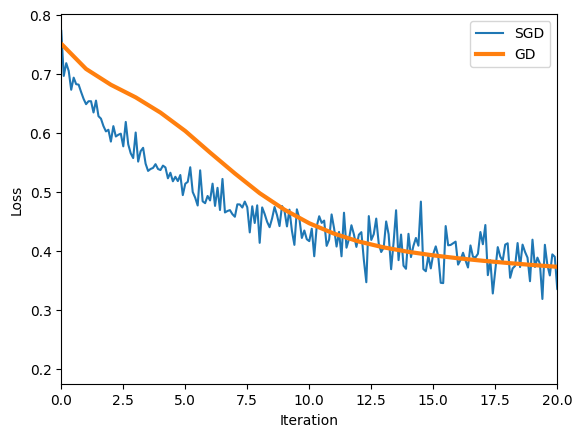

In [28]:
plt.plot(np.arange(len(sgd_losses)) / 10, sgd_losses, label="SGD")
plt.plot(losses, lw=3, label="GD")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.xlim(0, 20)
plt.legend()
plt.show()

In [29]:
logits = model(x).detach()
labels = (logits > 0).numpy()
accuracy_score(y, labels)

0.857

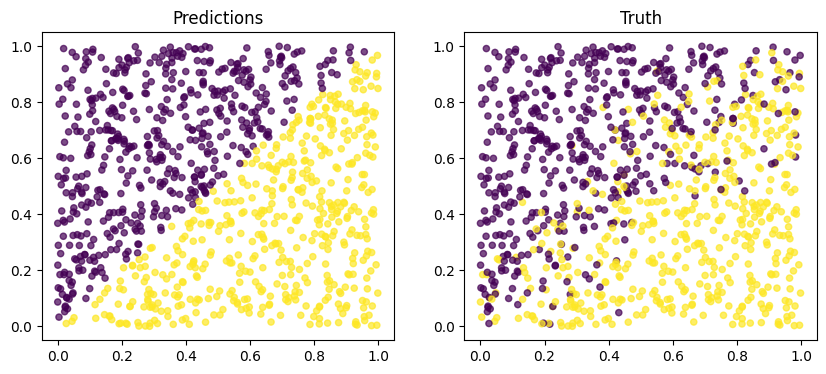

In [30]:
fig, (a0, a1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
a0.scatter(X[:, 0], X[:, 1], c=labels, s=20, alpha=0.7)
a0.set_title("Predictions")
a1.scatter(X[:, 0], X[:, 1], c=y, s=20, alpha=0.7)
a1.set_title("Truth")
plt.show()

### `nn.Module`

In [31]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
        logits = self.linear(x)
        return logits

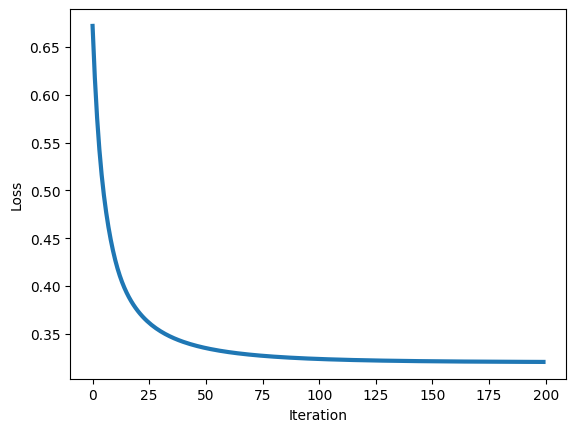

In [32]:
model = Model()

x = torch.Tensor(X)
y = torch.Tensor(y)


sgd = optim.SGD(model.parameters(), lr=6.0)
losses = []
for i in range(200):  # training loop
    logits = model(x)
    loss = compute_loss(logits.squeeze(), y)
    losses.append(loss.detach().item())

    loss.backward()
    with torch.no_grad():
        sgd.step()
        sgd.zero_grad()

plt.plot(losses, lw=3)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

X.shape=torch.Size([5000, 2]), y.shape=torch.Size([5000, 1])


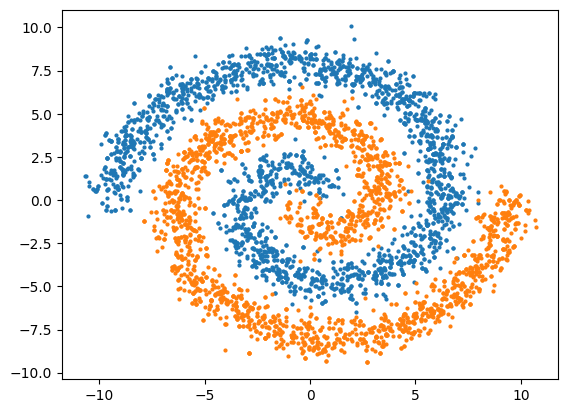

In [33]:
n = 2500
s = 0.6
k = 3
r0 = np.sqrt(np.random.uniform(size=n)) * k * np.pi
r1 = np.sqrt(np.random.uniform(size=n)) * k * np.pi
X0 = np.array([r0 * np.cos(r0), r0 * np.sin(r0)]).T + np.random.normal(
    0, s, size=(n, 2)
)
y0 = np.zeros(n)
X1 = np.array([r1 * np.cos(r1 + np.pi), r1 * np.sin(r1 + np.pi)]).T + np.random.normal(
    0, s, size=(n, 2)
)
y1 = np.ones(n)
X = np.vstack([X0, X1])
y = np.concatenate([y0, y1])
I = np.random.choice(range(2 * n), size=2 * n)
X = X[I, :]
y = y[I]

N = n
plt.plot(X[y == 0, 0][:N], X[y == 0, 1][:N], "o", ms=2)
plt.plot(X[y == 1, 0][:N], X[y == 1, 1][:N], "o", ms=2)

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

X = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(y.reshape(-1, 1).astype(np.float32))

print(f"X.shape={X.shape}, y.shape={y.shape}")

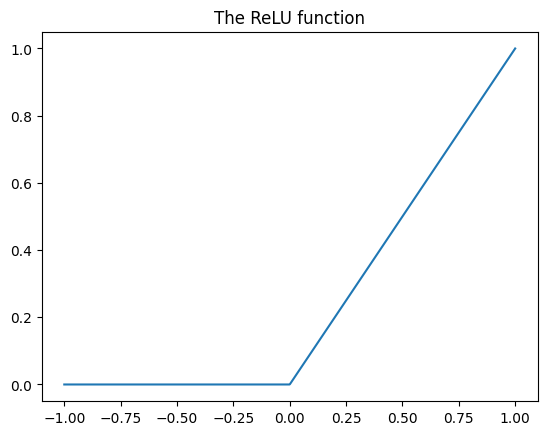

In [34]:
t = torch.linspace(-1, 1, 1000)
plt.title("The ReLU function")
plt.plot(t, F.relu(t))
plt.show()

In [45]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.L0 = torch.nn.Linear(2, 32)
        self.L1 = torch.nn.Linear(32, 1)

    def forward(self, x):
        logits = self.L1(F.relu(self.L0((x))))
        return logits

In [46]:
model = Model()

for lr in [0.5, 0.1]:
    sgd = optim.SGD(model.parameters(), lr=lr)
    for i in range(1500):
        logits = model(X)
        loss = torch.nn.functional.binary_cross_entropy(F.sigmoid(logits), y)
        loss.backward()
        with torch.no_grad():
            sgd.step()
            sgd.zero_grad()
            labels = (logits > 0).detach().numpy()
            if i % 200 == 0:
                print(i, f"{accuracy_score(y, labels):.2f}")

0 0.59
200 0.82
400 0.83
600 0.83
800 0.80
1000 0.86
1200 0.84
1400 0.86
0 0.77
200 0.95
400 0.96
600 0.97
800 0.97
1000 0.97
1200 0.97
1400 0.98


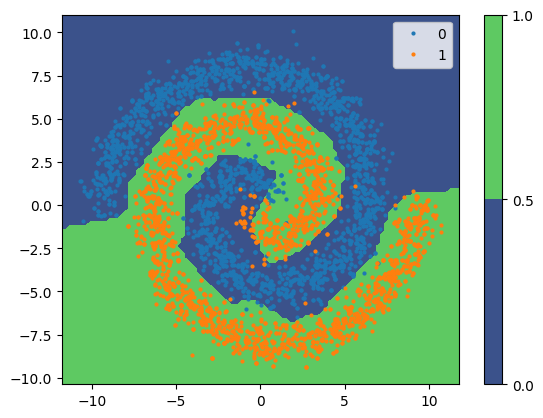

In [49]:
u0 = torch.linspace(xmin, xmax, 100)
u1 = torch.linspace(ymin, ymax, 100)
U0, U1 = torch.meshgrid(u0, u1, indexing="xy")
U = torch.hstack([U0.reshape(-1, 1), U1.reshape(-1, 1)])
with torch.no_grad():
    V = model(U).reshape(U0.shape) > 0
plt.contourf(U0, U1, V)
plt.colorbar()
plt.plot(X[y.squeeze() == 0, 0][:N], X[y.squeeze() == 0, 1][:N], "o", ms=2, label="0")
plt.plot(X[y.squeeze() == 1, 0][:N], X[y.squeeze() == 1, 1][:N], "o", ms=2, label="1")
plt.legend()
plt.show()

- There was a question along the lines of, "Can I work with probabilities instead of logits?"

- Yes, you can. See below. But I don't recommend it. Computationally, working with logits is probably more efficient. I concede, though, that thinking about logits doesn't have the same intuitive appeal as thinking about probabilities.

In [38]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.L0 = torch.nn.Linear(2, 32)
        self.L1 = torch.nn.Linear(32, 1)

    def forward(self, x):
        logits = self.L1(F.relu(self.L0((x))))
        probs = F.sigmoid(logits)
        return probs

In [39]:
model = Model()

for lr in [0.5, 0.1]:
    sgd = optim.SGD(model.parameters(), lr=lr)
    for i in range(1500):
        probs = model(X)
        loss = torch.nn.functional.binary_cross_entropy(probs, y)
        loss.backward()
        with torch.no_grad():
            sgd.step()
            sgd.zero_grad()
            labels = (probs > 0.5).detach().numpy()
            if i % 200 == 0:
                print(i, f"{accuracy_score(y, labels):.2f}")

0 0.55
200 0.79
400 0.83
600 0.84
800 0.85
1000 0.86
1200 0.90
1400 0.92
0 0.85
200 0.94
400 0.95
600 0.95
800 0.96
1000 0.96
1200 0.96
1400 0.97
